[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb)

When you haven't yet installed `tf-keras-vis` in your environment, please run the cell below.

In [1]:
# !pip install --upgrade pip
# !pip install --upgrade tf-keras-vis tensorflow matplotlib

(Please remove comment-out in the cell above when you want to install essential libraries to run tf-keras-vis.)

# Attention with Saliency and Class Activation Map

This notebook explain how to get various attention images with Saliency, SmoothGrad, GradCAM, GradCAM++ and ScoreCAM/Faster-ScoreCAM.

### Load libraries

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 0 GPUs


### Load tf.keras.Model

This example notebook uses VGG16 model in tf.keras, but if you want to use other tf.keras.Model, you can do so by modifying the section below.

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Load images

tf-keras-vis support evaluating batch-wisely that includes multiple images. Here, we load three pictures of goldfish, bear and assault-rifle as inputs data.

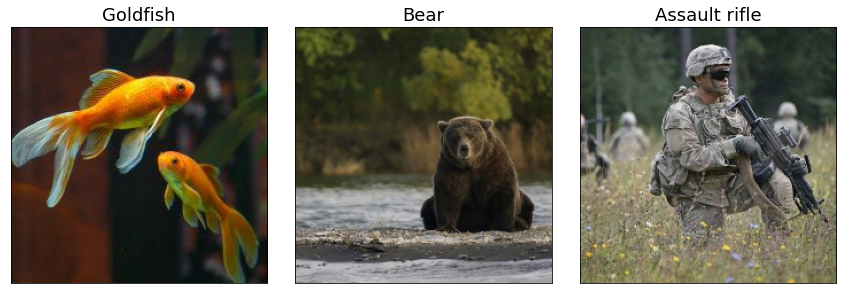

In [3]:
from tensorflow.keras.preprocessing.image import load_img

# Image titles
image_titles = ['Goldfish', 'Bear', 'Assault rifle']

# Load images and Convert them to a Numpy array
img1 = load_img('images/goldfish.jpg', target_size=(224, 224))
img2 = load_img('images/bear.jpg', target_size=(224, 224))
img3 = load_img('images/soldiers.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
X = preprocess_input(images)

# Rendering
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (12, 4),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=18)
    ax[i].imshow(images[i])
plt.tight_layout()
plt.show()

## Define necessary functions

### Model-Modifier function

First, when the softmax activation function is applied to the last layer of model, it may obstruct generating the attention images, so you need to replace the function to a linear function. Here, we will do so using `model_modifier`.

In [4]:
def model_modifier(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear
    return cloned_model

### Score function

And then, you MUST define `score` function that return target scores. Here, it returns the scores corresponding Goldfish, Bear, Assault Rifle.

In [5]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([1, 294, 413])

# Instead of CategoricalScore function object,
# you can also define the scratch function such as below:
def score_function(output):
    # The `output` variable refer to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][1], output[1][294], output[2][413])

## Vanilla Saliency

`Saliency` generate the saliency map that appears input regions that a change in the input value contribute the output value.

BTW, All attentions class constructors have `clone` option. When True, the model will be cloned, so the model instance will be NOT modified by attentions class, but it may take a while. 
In this notebook, because it does NOT need to do so, all setting False.

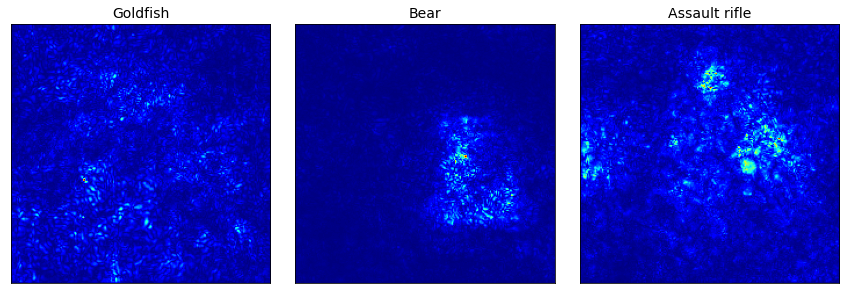

CPU times: user 14.2 s, sys: 882 ms, total: 15.1 s
Wall time: 2.7 s


In [6]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=model_modifier,
                    clone=False)

# Generate saliency map
saliency_map = saliency(score, X)

# Render
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
plt.tight_layout()
plt.show()

## SmoothGrad

As you can see above, Vanilla Saliency map is too noisy, so let's remove noise in the saliency map using SmoothGrad! SmoothGrad is a method that reduce noise including saliency map by adding noise to input image.

**Note:** Because SmoothGrad calculates gradients repeatedly, it takes much time around 2-3 minutes when using CPU.

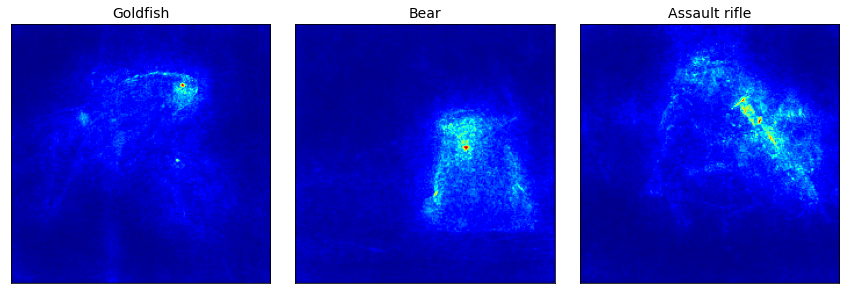

CPU times: user 1.5 s, sys: 200 ms, total: 1.7 s
Wall time: 1.47 s


In [7]:
%%time

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
plt.tight_layout()
plt.savefig('images/smoothgrad.png')
plt.show()

## GradCAM

Saliency is one of useful way of visualizing attention that appears input regions that a change in the input value contribute the output value.
GradCAM is another way of visualizing attention over input. Instead of using gradients with respect to model outputs, it uses penultimate (pre Dense layer) Conv layer output.

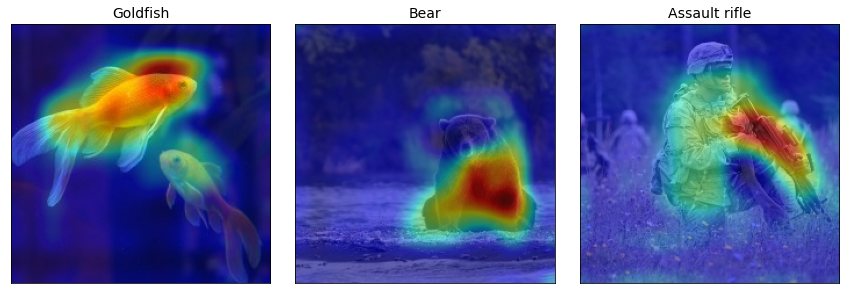

CPU times: user 615 ms, sys: 124 ms, total: 740 ms
Wall time: 504 ms


In [8]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=model_modifier,
                  clone=False)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1) # model.layers number

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
plt.tight_layout()
plt.show()

As you can see above, GradCAM is useful method for intuitively knowing where the attention is. But when you take a look closely, especially the head of Bear, you'll see that the visualized attentions don't completely cover the target (i.e., the Bear) that appear in the picture.

Okay then, let's move on to next method that is able to improve the problem above you looked.

## GradCAM++

GradCAM++ can provide better visual explanations of CNN model predictions.
In tf-keras-vis, GradcamPlusPlus (GradCAM++) class has most of compatibility with Gradcam. So you can use GradcamPlusPlus if you just replace classname from Gradcam to GradcamPlusPlus.

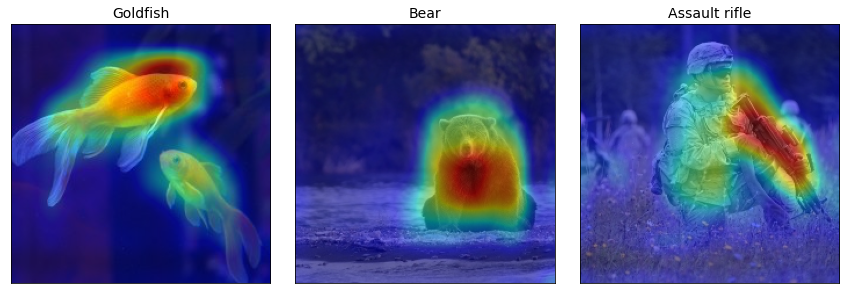

CPU times: user 913 ms, sys: 97.3 ms, total: 1.01 s
Wall time: 782 ms


In [9]:
%%time

from tf_keras_vis.gradcam import GradcamPlusPlus

# Create GradCAM++ object and repalce class name to "GradcamPlusPlus"
# gradcam = Gradcam(model,
#                   model_modifier,
#                   clone=False)
gradcam = GradcamPlusPlus(model,
                          model_modifier,
                          clone=False)

# Generate heatmap with GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.savefig('images/gradcam_plus_plus.png')
plt.show()

As you can see above, Now, the visualized attentions almost completely cover the target objects!

## ScoreCAM

Lastly, Here, we show you ScoreCAM. SocreCAM is an another method that generate Class Activation Map. The characteristic of this method is that it's the `gradient-free` CAM method unlike GradCAM/GradCAM++.

In default, this method takes too much time, so in the cell below ScoreCAM will be NOT run with CPU.

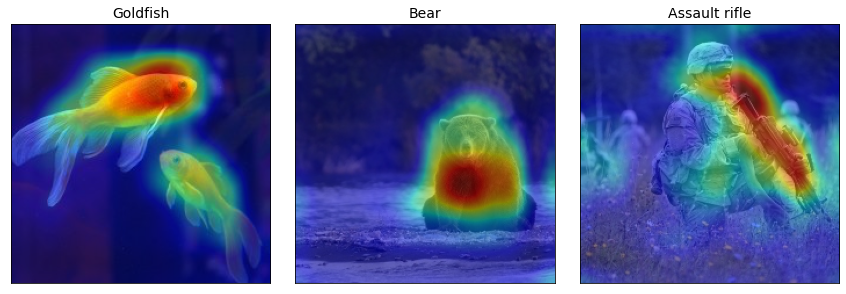

CPU times: user 4min 2s, sys: 2.18 s, total: 4min 4s
Wall time: 4min 3s


In [10]:
%%time

from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus

# This cell takes toooooooo much time, so only doing with GPU.
_, gpus = num_of_gpus()
if gpus > 0:
    # Create ScoreCAM object
    scorecam = Scorecam(model,
                        # As pointed out in https://github.com/keisen/tf-keras-vis/issues/47,
                        # ModelModier should be NOT applied with ScoreCAM.
                        model_modifier=None,
                        clone=False)

    # Generate heatmap with ScoreCAM
    cam = scorecam(score,
                   X,
                   penultimate_layer=-1)

    f, ax = plt.subplots(**subplot_args)
    for i, title in enumerate(image_titles):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        ax[i].set_title(title, fontsize=14)
        ax[i].imshow(images[i])
        ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("Let's run a next cell to show Faster-ScoreCAM")

## Faster-ScoreCAM

As you see above, ScoreCAM need huge processing power, but there is a good news for us. Faster-ScorecAM that makes ScoreCAM to be more efficient was devised by @tabayashi0117.

https://github.com/tabayashi0117/Score-CAM/blob/master/README.md#faster-score-cam
> We thought that several channels were dominant in generating the final heat map. Faster-Score-CAM adds the processing of “use only channels with large variances as mask images” to Score-CAM. (max_N = -1 is the original Score-CAM).


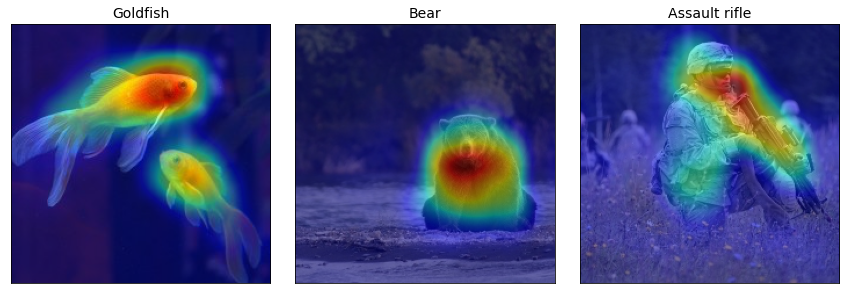

CPU times: user 14.5 s, sys: 289 ms, total: 14.8 s
Wall time: 14.5 s


In [11]:
%%time

from tf_keras_vis.scorecam import Scorecam

# Create ScoreCAM object
scorecam = Scorecam(model,
                    # As pointed out in https://github.com/keisen/tf-keras-vis/issues/47,
                    # ModelModier should be NOT applied with ScoreCAM.
                    model_modifier=None,
                    clone=False)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=10)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()

But it's still slow, so we recommend to use GradCAM++ if you don't have any reason such as you need gradient-free methods.